In [24]:
import random
import pylab as plt
import torch
import numpy as np
import torch.nn as nn

from tqdm.auto import tqdm
from sklearn import datasets
from dal_toolbox.models.deterministic.train import train_one_epoch
from dal_toolbox.models.deterministic.evaluate import evaluate

In [25]:
def stochasitc_augmentation(X: torch.tensor, noise: float = 1):
    return X + torch.randn_like(X)*noise

In [26]:
class SSLDataset(torch.utils.data.TensorDataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, idx):
        X, y = self.data[idx], self.targets[idx]
        return stochasitc_augmentation(X, 0.05), stochasitc_augmentation(X, 0.05), y
    
    def __len__(self):
        return self.data.shape[0]

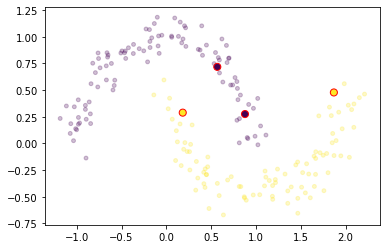

In [27]:
X, y = datasets.make_moons(300, noise=.1, random_state=42)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

random.seed(3)
test_indices = random.sample(range(X.shape[0]), k = 100)
train_indices = [i for i in range(X.shape[0]) if i not in test_indices]
labeled_indices = random.sample(train_indices, k=4)
labeled_ds = torch.utils.data.TensorDataset(X[labeled_indices], y[labeled_indices])
unlabeled_ds = SSLDataset(X[train_indices], y[train_indices])
test_ds = torch.utils.data.TensorDataset(X[test_indices], y[test_indices])

plt.scatter(X[train_indices, 0], X[train_indices, 1], c=y[train_indices], s=15, alpha=.25)
plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=50, edgecolors='red')
plt.show()

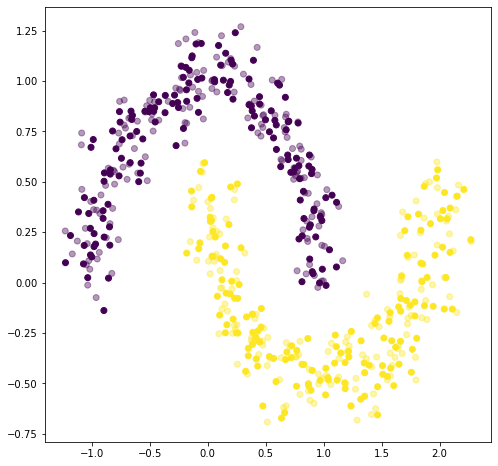

In [28]:
# What are useful values for noise?

X_trans = stochasitc_augmentation(X, 0.05)

fix = plt.figure(figsize=(8,8))
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(X_trans[:,0], X_trans[:,1], c=y, alpha=0.4)
plt.show()

In [29]:
@torch.no_grad()
def plot_contour(model, X_l, y_l, X_u, y_u, ax=None):
    model.eval()
    model.cpu()
    origin = 'lower'
    if ax:
        plt.sca(ax)
    domain = 3
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51), indexing='ij')
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    plt.scatter(X_l[:, 0], X_l[:, 1], c=y_l, s=50, edgecolors='red')
    plt.scatter(X_u[:, 0], X_u[:, 1], c=y_u, s=15, alpha=.25)
    CS = plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6), origin=origin)
    CS2 = plt.contour(CS, levels=[0.5], colors='black', origin=origin)
    cbar = plt.colorbar(CS)
    cbar.add_lines(CS2)

In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Net
        self.layer1 = nn.Linear(2, 128)
        self.act = nn.functional.relu

        self.layer3 = nn.Linear(128, 16)

    def forward(self, X, get_projections=False):
        X = self.layer1(X)
        X = self.act(X)

        if get_projections:
            X = self.layer3(X)
            X = self.act(X)
            return X
        
        return X

In [31]:
def train_one_epoch_simclr(model, optimizer, criterion_sup, criterion_unsup, supervised_loader, unsupervised_loader, lmbd, device='cuda'):
    model.train()
    model.to(device)
    criterion_sup.to(device)
    criterion_unsup.to(device)

    total_loss_sup, total_loss_unsup, n_samples_l, n_samples_ul = 0, 0, 0, 0

    # Train the epoch
    for (x_l, y_l), (x_ul_A, x_ul_B, _) in zip(supervised_loader, unsupervised_loader):
        x_l, y_l, x_ul_A, x_ul_B = x_l.to(device), y_l.to(device), x_ul_A.to(device), x_ul_B.to(device)
        bs_l, bs_ul = x_l.shape[0], x_ul_A.shape[0]

        x_ul = torch.cat([x_ul_A, x_ul_B], dim=0)

        # Supervised loss
        out_l = model(x_l, get_projections=False)
        loss_l = criterion_sup(out_l, y_l)

        # Unsupervised loss
        out_ul = model(x_ul, get_projections=True)
        loss_ul = criterion_unsup(out_ul)

        loss = loss_l + lmbd*loss_ul

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_sup += loss_l.item() * bs_l
        total_loss_unsup += loss_ul.item() * bs_ul * 2

        n_samples_l += bs_l
        n_samples_ul += bs_ul * 2

    return total_loss_sup/n_samples_l, total_loss_unsup/n_samples_ul

In [32]:
class NTXent(nn.Module):
    def __init__(self, T):
        super(NTXent, self).__init__()
        self.sim = nn.CosineSimilarity(dim=-1)
        self.T = T
        self.device='cuda'

    def forward(self, X):
        batch_size = X.shape[0]//2
        n_samples = 0

        total_loss = torch.tensor(0, dtype=torch.float).to(self.device)
        for i in range(batch_size):

            j = i + batch_size

            loss_i_j = (-1) * torch.log( 
                torch.exp(self.sim(X[i], X[j])/self.T) /
                torch.sum(torch.tensor([torch.exp(self.sim(X[i], X[k]) / self.T) for k in range(2*batch_size) if k != i]).to(self.device))
            )
            loss_j_i = (-1) * torch.log( 
                torch.exp(self.sim(X[j], X[i])/self.T) /
                torch.sum(torch.tensor([torch.exp(self.sim(X[j], X[k]) / self.T) for k in range(2*batch_size) if k != j]).to(self.device))
            )

            total_loss += loss_i_j + loss_j_i
            n_samples += 2
        
        return total_loss/n_samples

  0%|          | 0/1000 [00:00<?, ?it/s]

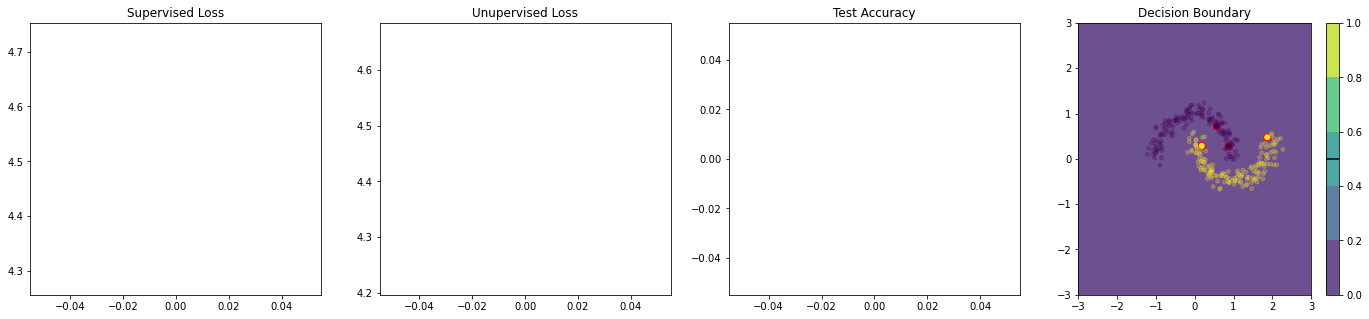

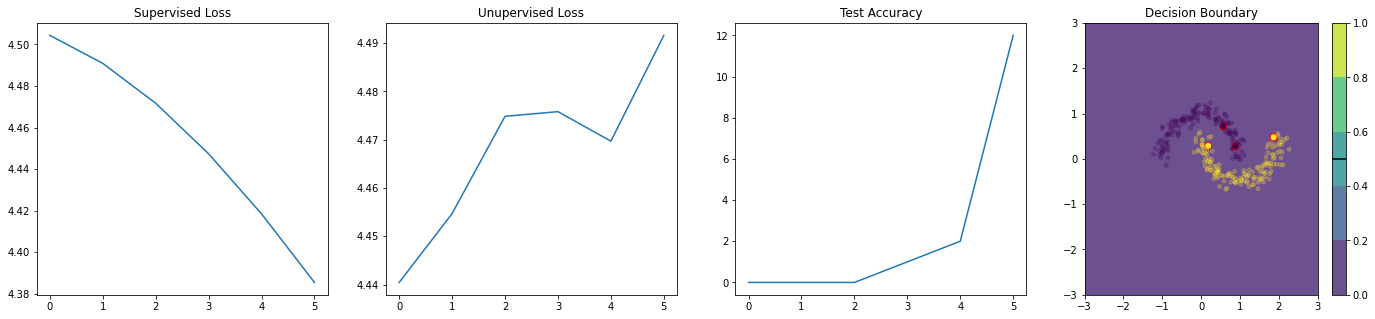

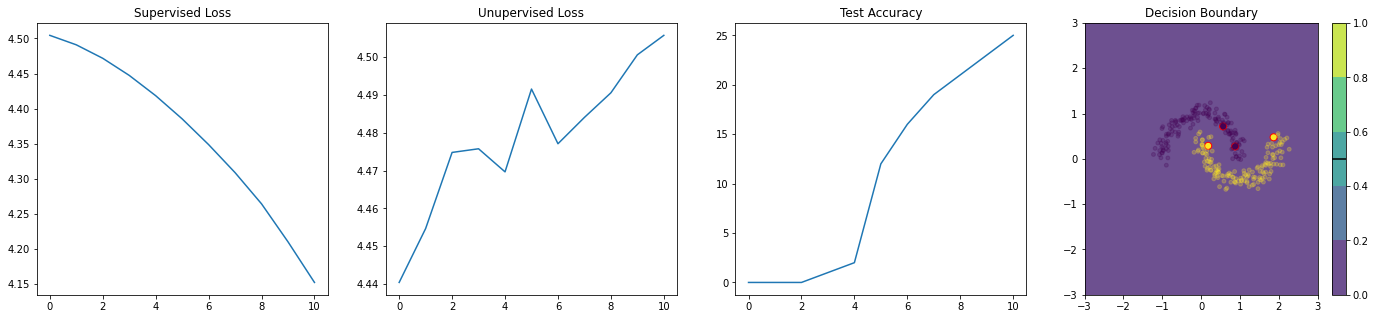

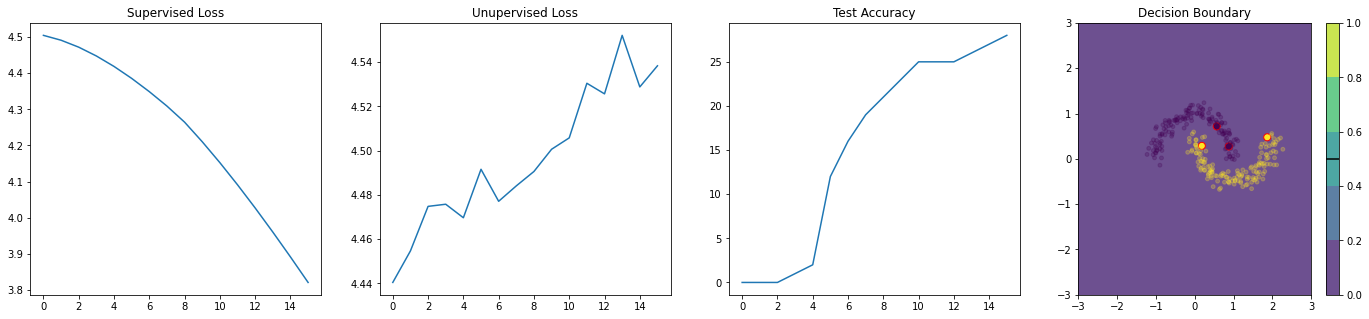

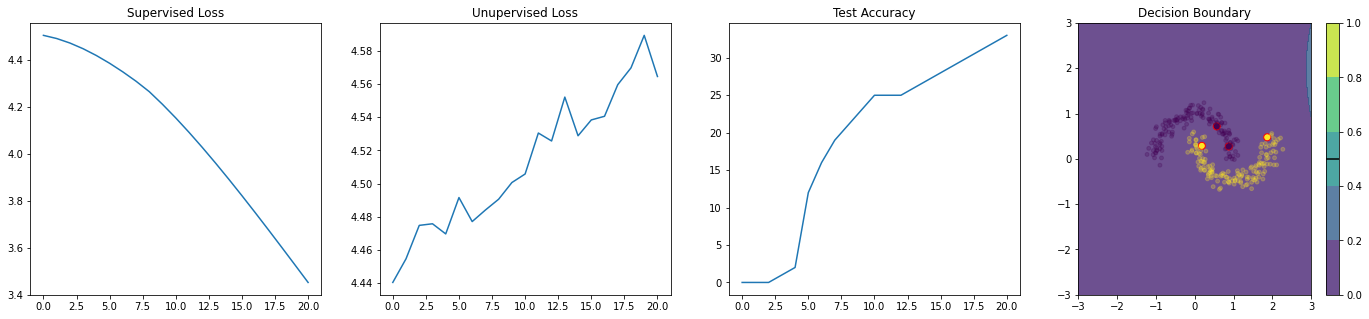

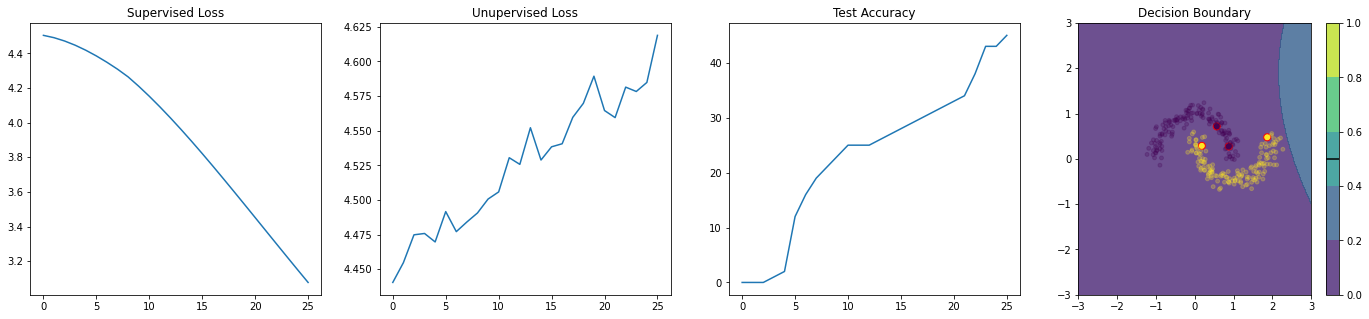

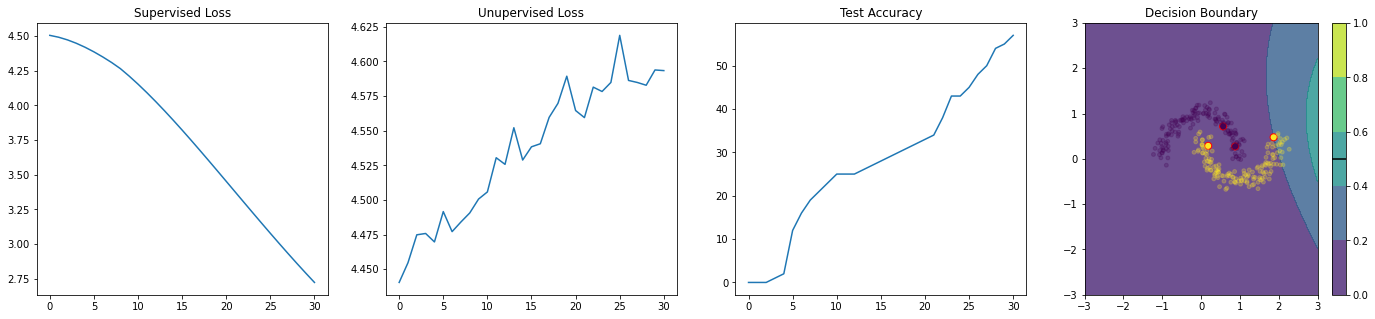

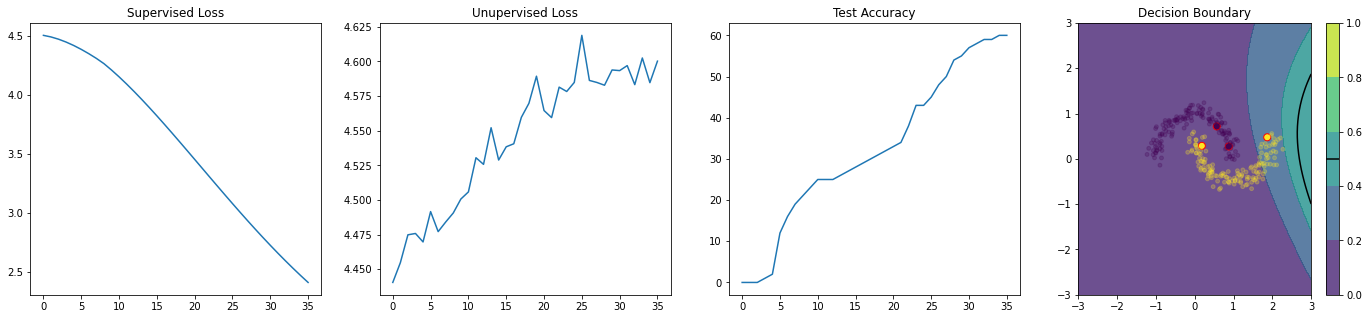

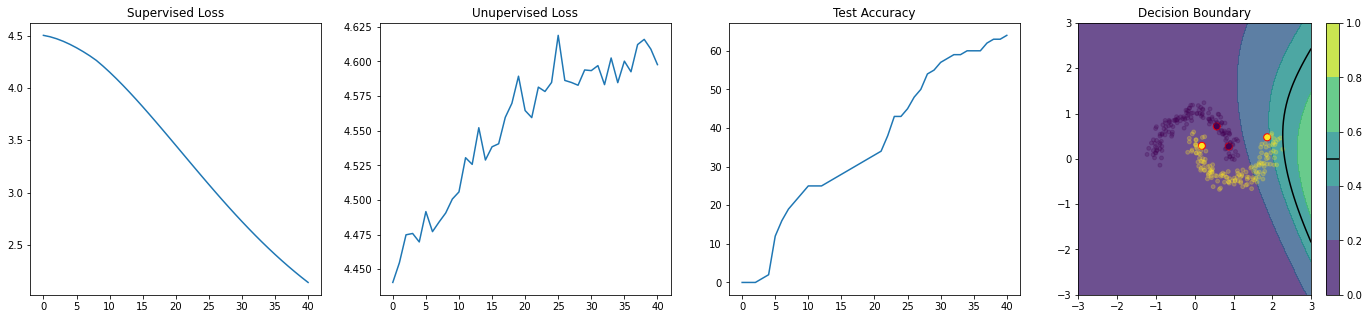

KeyboardInterrupt: 

In [33]:
n_epochs = 1000
n_iter_per_epoch = 1
batch_size = 8
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4
lmbd = 5
u_ratio = 7

model = Net()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)

labeled_sampler = torch.utils.data.RandomSampler(labeled_ds, generator=torch.Generator().manual_seed(42), num_samples=n_iter_per_epoch*batch_size)
unlabeled_sampler = torch.utils.data.RandomSampler(unlabeled_ds, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)

dataloader_sup = torch.utils.data.DataLoader(labeled_ds, batch_size=batch_size, sampler=labeled_sampler)
dataloader_unsup = torch.utils.data.DataLoader(unlabeled_ds, batch_size=u_ratio * batch_size, sampler=unlabeled_sampler)
dataloader_val = torch.utils.data.DataLoader(test_ds, batch_size=64)

criterion_sup = nn.CrossEntropyLoss()
criterion_unsup = NTXent(T=0.5)

dataloaders = {
    'supervised_loader':dataloader_sup,
    'unsupervised_loader':dataloader_unsup
}

history = []

for i in tqdm(range(n_epochs)):
    loss_sup, loss_unsup = train_one_epoch_simclr(model, optimizer, criterion_sup, criterion_unsup, **dataloaders, lmbd=lmbd)
    test_acc = evaluate(model, dataloader_val, {}, criterion_sup, device='cuda')['test_acc1']
    history.append(
        {
        'loss_sup':loss_sup,
        'loss_unsup':loss_unsup,
        'test_acc':test_acc
        }
    )
    if (i % 5 == 0) or (i == n_epochs-1):
        fig, ax = plt.subplots(1, 4, figsize=(24,5))
        ax[0].plot([h['loss_sup'] for h in history])
        ax[0].set_title("Supervised Loss")
        ax[1].plot([h['loss_unsup'] for h in history])
        ax[1].set_title("Unupervised Loss")
        ax[2].plot([h['test_acc'] for h in history])
        ax[2].set_title("Test Accuracy")
        plot_contour(model, X[labeled_indices], y[labeled_indices], X, y, ax=ax[3])
        ax[3].set_title("Decision Boundary")
        plt.show()


In [ ]:
def pretrain_one_epoch_simclr(model, optimizer, criterion, unsupervised_loader, lmbd, device='cuda'):
    model.train()
    model.to(device)
    criterion_sup.to(device)
    criterion_unsup.to(device)

    total_loss_unsup, n_samples_ul = 0, 0

    # Train the epoch
    for (x_ul_A, x_ul_B, _) in unsupervised_loader:
        x_ul_A, x_ul_B = x_ul_A.to(device), x_ul_B.to(device)
        bs_ul = x_ul_A.shape[0]

        x_ul = torch.cat([x_ul_A, x_ul_B], dim=0)

        # Unsupervised loss
        out_ul = model(x_ul, get_projections=True)
        loss_ul = criterion(out_ul)

        loss = lmbd*loss_ul

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_unsup += loss_ul.item() * bs_ul * 2

        n_samples_ul += bs_ul * 2

    return 0, total_loss_unsup/n_samples_ul

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc = nn.Linear(128, 2)

    def forward(self, X):
        X = self.fc(X)
        return X

In [ ]:
def sup_train_one_epoch_simclr(model, feature_extractor, optimizer, criterion_sup, supervised_loader, lmbd, device='cuda'):
    model.train()
    model.to(device)
    feature_extractor.to(device)
    criterion_sup.to(device)
    criterion_unsup.to(device)

    total_loss_sup, n_samples_l = 0, 0

    # Train the epoch
    for (x_l, y_l) in supervised_loader:
        x_l, y_l = x_l.to(device), y_l.to(device)
        bs_l = x_l.shape[0]

        # Supervised loss
        with torch.no_grad():
            features = feature_extractor(x_l)
        out_l = model(features)
        loss_l = criterion_sup(out_l, y_l)

        loss = loss_l

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss_sup += loss_l.item() * bs_l

        n_samples_l += bs_l

    return total_loss_sup/n_samples_l, 0

In [ ]:
n_epochs = 1000
n_iter_per_epoch = 1
batch_size = 8
learning_rate = 1e-2
momentum = 0.9
weight_decay = 5e-4
lmbd = 5
u_ratio = 7

feature_extractor = Net()
model = Net2()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
optimizer_2 = torch.optim.SGD(feature_extractor.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay, nesterov=True)
lr_scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_2, T_max=n_epochs)

labeled_sampler = torch.utils.data.RandomSampler(labeled_ds, generator=torch.Generator().manual_seed(42), num_samples=n_iter_per_epoch*batch_size)
unlabeled_sampler = torch.utils.data.RandomSampler(unlabeled_ds, generator=torch.Generator().manual_seed(42), num_samples=u_ratio*n_iter_per_epoch*batch_size)

dataloader_sup = torch.utils.data.DataLoader(labeled_ds, batch_size=batch_size, sampler=labeled_sampler)
dataloader_unsup = torch.utils.data.DataLoader(unlabeled_ds, batch_size=u_ratio * batch_size, sampler=unlabeled_sampler)
dataloader_val = torch.utils.data.DataLoader(test_ds, batch_size=64)

criterion_sup = nn.CrossEntropyLoss()
criterion_unsup = NTXent(T=0.5)

dataloaders = {
    'supervised_loader':dataloader_sup,
    'unsupervised_loader':dataloader_unsup
}

history = []

for i in tqdm(range(n_epochs)):
    loss_sup, loss_unsup = train_one_epoch_simclr(model, optimizer, criterion_sup, criterion_unsup, **dataloaders, lmbd=lmbd)
    test_acc = evaluate(model, dataloader_val, {}, criterion_sup, device='cuda')['test_acc1']
    history.append(
        {
        'loss_sup':loss_sup,
        'loss_unsup':loss_unsup,
        'test_acc':test_acc
        }
    )
    if (i % 5 == 0) or (i == n_epochs-1):
        fig, ax = plt.subplots(1, 4, figsize=(24,5))
        ax[0].plot([h['loss_sup'] for h in history])
        ax[0].set_title("Supervised Loss")
        ax[1].plot([h['loss_unsup'] for h in history])
        ax[1].set_title("Unupervised Loss")
        ax[2].plot([h['test_acc'] for h in history])
        ax[2].set_title("Test Accuracy")
        plot_contour(model, X[labeled_indices], y[labeled_indices], X, y, ax=ax[3])
        ax[3].set_title("Decision Boundary")
        plt.show()
